### Read cleaned file

In [1]:
import numpy as np
import pandas as pd 
import os
from tqdm import tqdm
import glob
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import scipy.stats as stats
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, AffinityPropagation
from scipy.stats import mode
import time
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import optuna
from sklearn.model_selection import train_test_split


In [2]:
# Specify the path to your CSV file
file_path = 'preprocesseddata.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Now, you have your CSV data in a DataFrame 'df'
df

,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,main_category,sub_category,year,month,day,weekday,timing
0,view,1004741,2053013555631882655,electronics.smartphone,xiaomi,13.782960,560357322,fe9dfa6b-9370-45e4-8480-995473e91b1e,electronics,smartphone,2019,10,25,4,early morning
1,view,12500227,2053013556277805513,electronics.smartphone,makita,8.489405,530873608,044a0dd2-3a47-4a7c-bf57-a873d190dfd6,electronics,smartphone,2019,10,9,2,midnight
2,view,5100816,2053013553375346967,electronics.smartphone,xiaomi,5.436911,548502025,e5309517-4158-4312-abf2-e8780879f336,electronics,smartphone,2019,10,2,2,early morning
3,view,1004653,2053013555631882655,electronics.smartphone,samsung,25.225186,554347151,0191fc4e-9840-4158-96d8-65ef2b328332,electronics,smartphone,2019,10,13,6,night
4,view,3700926,2053013565983425517,appliances.environment.vacuum,samsung,8.001250,555140963,d4d2d6d5-3060-4aea-b895-21716e53781f,appliances,environment.vacuum,2019,10,15,1,morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,view,12705188,2053013553559896355,electronics.smartphone,samsung,6.245799,534090743,f1a966bb-883b-44f8-b037-989909594f5f,electronics,smartphone,2019,10,16,2,midnight
49996,view,2601936,2053013563970159485,electronics.smartphone,dauscher,22.109274,518923212,9d8ac2be-1440-4354-b96d-079de06f7d3b,electronics,smartphone,2019,10,27,6,afternoon
49997,view,1004833,2053013555631882655,electronics.smartphone,samsung,13.068665,562836639,c5a79923-57b5-40f5-af5e-10e59a350689,electronics,smartphone,2019,10,24,3,midnight
49998,view,1003311,2053013555631882655,electronics.smartphone,apple,26.552589,517214173,7a19da89-c980-48a4-aae2-7fa9fb745b1a,electronics,smartphone,2019,10,24,3,afternoon


### removing some unwanted features

In [3]:
df = df.drop(['user_session', 'category_code'], axis=1)

In [4]:
df

,event_type,product_id,category_id,brand,price,user_id,main_category,sub_category,year,month,day,weekday,timing
0,view,1004741,2053013555631882655,xiaomi,13.782960,560357322,electronics,smartphone,2019,10,25,4,early morning
1,view,12500227,2053013556277805513,makita,8.489405,530873608,electronics,smartphone,2019,10,9,2,midnight
2,view,5100816,2053013553375346967,xiaomi,5.436911,548502025,electronics,smartphone,2019,10,2,2,early morning
3,view,1004653,2053013555631882655,samsung,25.225186,554347151,electronics,smartphone,2019,10,13,6,night
4,view,3700926,2053013565983425517,samsung,8.001250,555140963,appliances,environment.vacuum,2019,10,15,1,morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,view,12705188,2053013553559896355,samsung,6.245799,534090743,electronics,smartphone,2019,10,16,2,midnight
49996,view,2601936,2053013563970159485,dauscher,22.109274,518923212,electronics,smartphone,2019,10,27,6,afternoon
49997,view,1004833,2053013555631882655,samsung,13.068665,562836639,electronics,smartphone,2019,10,24,3,midnight
49998,view,1003311,2053013555631882655,apple,26.552589,517214173,electronics,smartphone,2019,10,24,3,afternoon


### label encoding

In [5]:
catls=['event_type', 'main_category', 'sub_category', 'brand','timing']
encoding_mapping = {}
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Iterate through columns and apply label encoding to categorical columns
for column in catls:  # Check if the column is categorical (object type)
        df[column] = label_encoder.fit_transform(df[column])
         # Create mapping for each column
        encoding_mapping[column] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

df

,event_type,product_id,category_id,brand,price,user_id,main_category,sub_category,year,month,day,weekday,timing
0,2,1004741,2053013555631882655,1520,13.782960,560357322,7,97,2019,10,25,4,1
1,2,12500227,2053013556277805513,858,8.489405,530873608,7,97,2019,10,9,2,3
2,2,5100816,2053013553375346967,1520,5.436911,548502025,7,97,2019,10,2,2,1
3,2,1004653,2053013555631882655,1230,25.225186,554347151,7,97,2019,10,13,6,5
4,2,3700926,2053013565983425517,1230,8.001250,555140963,2,42,2019,10,15,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,12705188,2053013553559896355,1230,6.245799,534090743,7,97,2019,10,16,2,3
49996,2,2601936,2053013563970159485,366,22.109274,518923212,7,97,2019,10,27,6,0
49997,2,1004833,2053013555631882655,1230,13.068665,562836639,7,97,2019,10,24,3,3
49998,2,1003311,2053013555631882655,83,26.552589,517214173,7,97,2019,10,24,3,0


### Scaling Features

In [6]:
# Create a StandardScaler instance
#scaler = StandardScaler()
# Create a MinMaxScaler instance
scaler = MinMaxScaler()
# Specify the columns you want to scale
columns_to_scale = ['product_id', 'category_id', 'user_id']

In [7]:

# Fit and transform the specified columns
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [8]:
df

,event_type,product_id,category_id,brand,price,user_id,main_category,sub_category,year,month,day,weekday,timing
0,2,0.000064,2.782359e-08,1520,13.782960,0.980327,7,97,2019,10,25,4,1
1,2,0.196572,3.310047e-08,858,8.489405,0.882267,7,97,2019,10,9,2,3
2,2,0.070084,9.388746e-09,1520,5.436911,0.940898,7,97,2019,10,2,2,1
3,2,0.000063,2.782359e-08,1230,25.225186,0.960338,7,97,2019,10,13,6,5
4,2,0.046154,1.123908e-07,1230,8.001250,0.962978,2,42,2019,10,15,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,0.200075,1.089643e-08,1230,6.245799,0.892967,7,97,2019,10,16,2,3
49996,2,0.027367,9.594340e-08,366,22.109274,0.842521,7,97,2019,10,27,6,0
49997,2,0.000066,2.782359e-08,1230,13.068665,0.988573,7,97,2019,10,24,3,3
49998,2,0.000040,2.782359e-08,83,26.552589,0.836837,7,97,2019,10,24,3,0


### PCA

In [9]:
pca = PCA()
pca.fit(df) 
pca.explained_variance_ratio_

array([9.95568037e-01, 3.85834126e-03, 3.20780402e-04, 2.08249912e-04,
       1.65091084e-05, 1.62343553e-05, 1.11564173e-05, 4.33038800e-07,
       1.83889721e-07, 5.80156620e-08, 1.63383013e-08, 5.62602687e-40,
       4.05444539e-42])

In [10]:
pca = PCA(n_components = 2)
pca.fit(df)
pca.components_

array([[-4.97207609e-06, -4.98200794e-05, -1.27329328e-05,
        -9.99982450e-01,  4.10976443e-03, -1.88389352e-06,
        -3.29169398e-04, -4.24198128e-03,  0.00000000e+00,
         0.00000000e+00, -3.16817137e-04,  2.16925294e-05,
         5.24915084e-05],
       [ 3.49066709e-04, -2.53220820e-04, -5.84239142e-05,
         4.07614109e-03, -4.14911039e-02, -9.05280574e-05,
        -2.47312749e-02, -9.98813605e-01, -0.00000000e+00,
        -0.00000000e+00, -4.59670454e-03,  2.11137767e-04,
         4.97955021e-04]])

In [11]:
df_pca_comp = pd.DataFrame(data = pca.components_,
                           columns = df.columns,
              index = ['Component 1', 'Component 2'])
df_pca_comp

,event_type,product_id,category_id,brand,price,user_id,main_category,sub_category,year,month,day,weekday,timing
Component 1,-0.000005,-0.000050,-0.000013,-0.999982,0.004110,-0.000002,-0.000329,-0.004242,0.0,0.0,-0.000317,0.000022,0.000052
Component 2,0.000349,-0.000253,-0.000058,0.004076,-0.041491,-0.000091,-0.024731,-0.998814,-0.0,-0.0,-0.004597,0.000211,0.000498


In [12]:
pca.transform(df)
scores_pca = pca.transform(df)
scores_pca

array([[-637.70248176,  -14.13394095],
       [  24.2692661 ,  -16.53863088],
       [-637.72954206,  -13.68236637],
       ...,
       [-347.71010668,  -15.28100422],
       [ 799.32502232,  -20.51728109],
       [-637.66865772,  -14.33372582]])

### Kmeans

##### ELBOW METHOD

In [13]:
wcss = []
for i in range(1,11):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

C:\Users\Dedu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Dedu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Dedu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Dedu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_

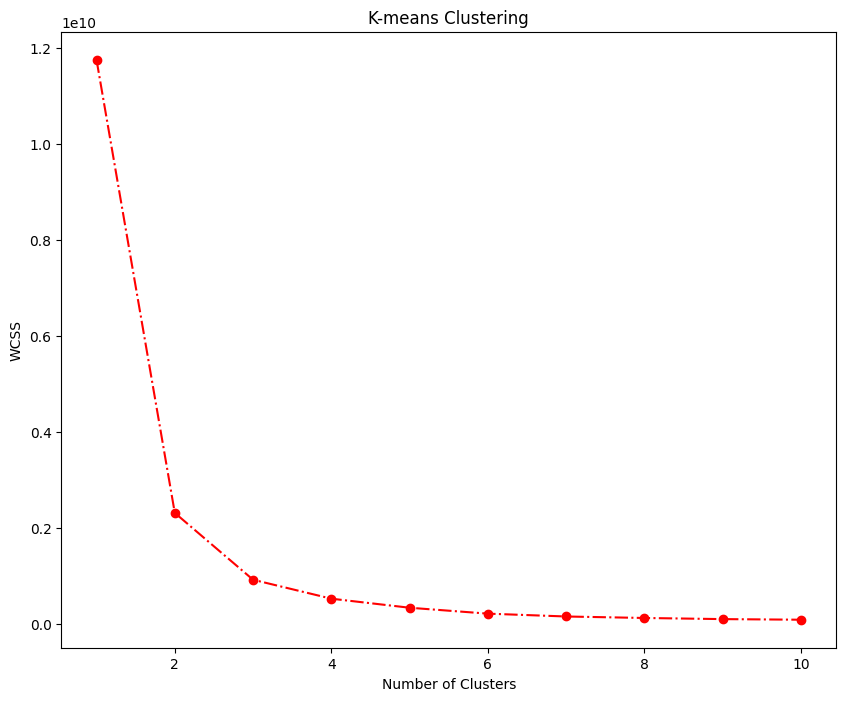

In [14]:
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '-.',color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.show()

In [15]:
# Initialize and fit K-Means with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit_predict(scores_pca)
df_kmeans= df.copy()
df_kmeans = pd.concat([df.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_kmeans.columns.values[-2: ] = ['Component 1', 'Component 2']
df_kmeans['Segment K-means'] = kmeans.labels_
df_kmeans

C:\Users\Dedu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,event_type,product_id,category_id,brand,price,user_id,main_category,sub_category,year,month,day,weekday,timing,Component 1,Component 2,Segment K-means
0,2,0.000064,2.782359e-08,1520,13.782960,0.980327,7,97,2019,10,25,4,1,-637.702482,-14.133941,0
1,2,0.196572,3.310047e-08,858,8.489405,0.882267,7,97,2019,10,9,2,3,24.269266,-16.538631,0
2,2,0.070084,9.388746e-09,1520,5.436911,0.940898,7,97,2019,10,2,2,1,-637.729542,-13.682366,0
3,2,0.000063,2.782359e-08,1230,25.225186,0.960338,7,97,2019,10,13,6,5,-347.656491,-15.733196,0
4,2,0.046154,1.123908e-07,1230,8.001250,0.962978,2,42,2019,10,15,1,4,-347.493120,40.029090,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,0.200075,1.089643e-08,1230,6.245799,0.892967,7,97,2019,10,16,2,3,-347.735644,-14.961395,0
49996,2,0.027367,9.594340e-08,366,22.109274,0.842521,7,97,2019,10,27,6,0,516.310841,-19.192539,1
49997,2,0.000066,2.782359e-08,1230,13.068665,0.988573,7,97,2019,10,24,3,3,-347.710107,-15.281004,0
49998,2,0.000040,2.782359e-08,83,26.552589,0.836837,7,97,2019,10,24,3,0,799.325022,-20.517281,1


In [16]:
df_segm_analysis = df_kmeans.groupby(['Segment K-means']).mean()
df_segm_analysis

,event_type,product_id,category_id,brand,price,user_id,main_category,sub_category,year,month,day,weekday,timing,Component 1,Component 2
Segment K-means,,,,,,,,,,,,,,,
0,1.939052,0.186843,0.042357,1219.324190,12.978402,0.891966,6.037395,82.221200,2019.0,10.0,16.205915,2.940078,2.095203,-336.969436,-0.500401
1,1.937690,0.123069,0.023084,322.813015,15.860617,0.889825,5.754749,77.118236,2019.0,10.0,15.924174,2.960783,2.144362,559.559686,0.830949


In [17]:
df_segm_analysis.rename({0:'highly profitable',
                         1:'less profitable',
                        })

,event_type,product_id,category_id,brand,price,user_id,main_category,sub_category,year,month,day,weekday,timing,Component 1,Component 2
Segment K-means,,,,,,,,,,,,,,,
highly profitable,1.939052,0.186843,0.042357,1219.324190,12.978402,0.891966,6.037395,82.221200,2019.0,10.0,16.205915,2.940078,2.095203,-336.969436,-0.500401
less profitable,1.937690,0.123069,0.023084,322.813015,15.860617,0.889825,5.754749,77.118236,2019.0,10.0,15.924174,2.960783,2.144362,559.559686,0.830949


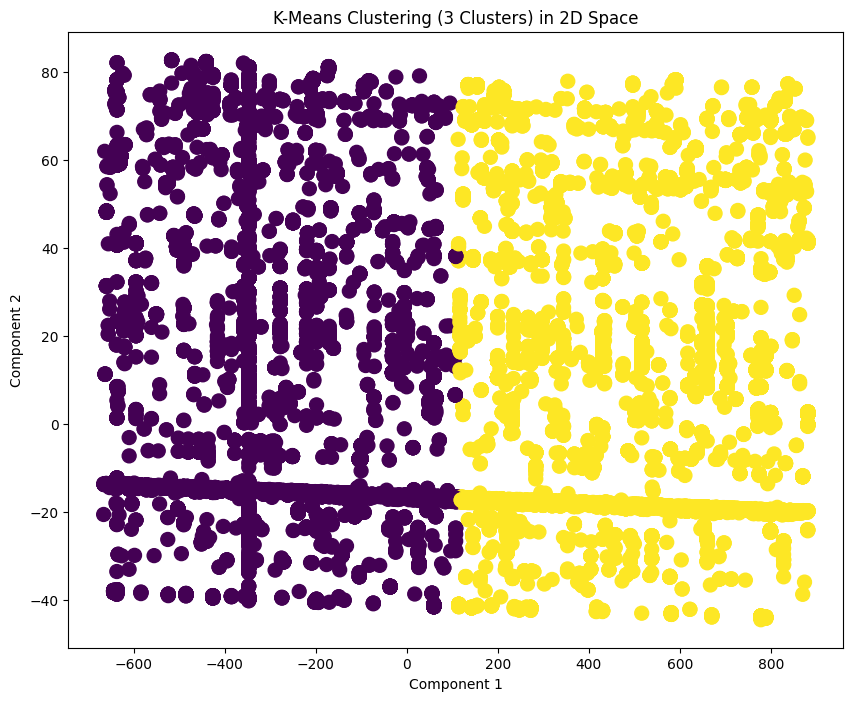

In [18]:
import matplotlib.pyplot as plt

# Create a 2D Scatter Plot
plt.figure(figsize=(10, 8))

x = df_kmeans['Component 1']
y = df_kmeans['Component 2']
c = df_kmeans['Segment K-means']

plt.scatter(x, y, c=c, cmap='viridis', s=100, marker='o')

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('K-Means Clustering (3 Clusters) in 2D Space')

plt.show()

In [19]:
sil=[]
dbin=[]
labels = kmeans.labels_  # Cluster labels
silhouette_avg = silhouette_score(scores_pca, labels)
db_index = davies_bouldin_score(scores_pca, labels)
print("Silhouette Score:", silhouette_avg)
print("Davies-Bouldin Index:", db_index)
sil.append(silhouette_avg)
dbin.append(db_index)

Silhouette Score: 0.6981058198047669
Davies-Bouldin Index: 0.40763403812857757


### Gaussian Mixture Clustering

In [20]:
# Initialize Gaussian Mixture Model with specified parameters
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
# Fit the model and get cluster labels
df_kmeans['segment gaussian'] = gmm.fit_predict(scores_pca)

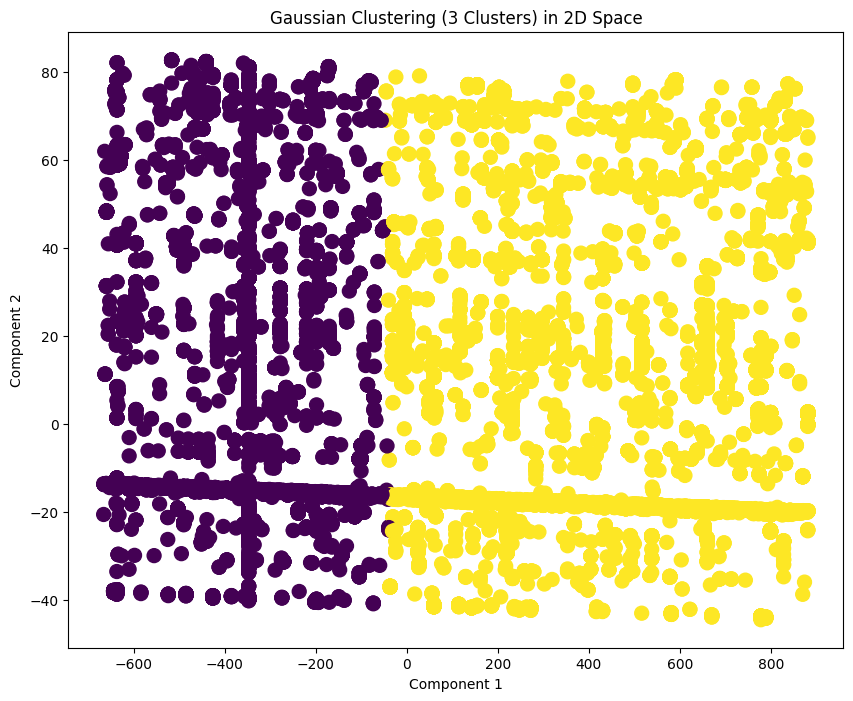

In [21]:
import matplotlib.pyplot as plt

# Create a 2D Scatter Plot
plt.figure(figsize=(10, 8))

x = df_kmeans['Component 1']
y = df_kmeans['Component 2']
c = df_kmeans['segment gaussian']

plt.scatter(x, y, c=c, cmap='viridis', s=100, marker='o')

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Gaussian Clustering (3 Clusters) in 2D Space')

plt.show()


In [22]:
# Calculate Silhouette Score
silhouette_avg = silhouette_score(scores_pca, df_kmeans['segment gaussian'])

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(scores_pca, df_kmeans['segment gaussian'])

# Print cluster evaluation metrics
print("Silhouette Score:", silhouette_avg)
print("Davies-Bouldin Index:", db_index)
sil.append(silhouette_avg)
dbin.append(db_index)

Silhouette Score: 0.6777575888820013
Davies-Bouldin Index: 0.45241334801177835


In [23]:
df_kmeans

,event_type,product_id,category_id,brand,price,user_id,main_category,sub_category,year,month,day,weekday,timing,Component 1,Component 2,Segment K-means,segment gaussian
0,2,0.000064,2.782359e-08,1520,13.782960,0.980327,7,97,2019,10,25,4,1,-637.702482,-14.133941,0,0
1,2,0.196572,3.310047e-08,858,8.489405,0.882267,7,97,2019,10,9,2,3,24.269266,-16.538631,0,1
2,2,0.070084,9.388746e-09,1520,5.436911,0.940898,7,97,2019,10,2,2,1,-637.729542,-13.682366,0,0
3,2,0.000063,2.782359e-08,1230,25.225186,0.960338,7,97,2019,10,13,6,5,-347.656491,-15.733196,0,0
4,2,0.046154,1.123908e-07,1230,8.001250,0.962978,2,42,2019,10,15,1,4,-347.493120,40.029090,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,0.200075,1.089643e-08,1230,6.245799,0.892967,7,97,2019,10,16,2,3,-347.735644,-14.961395,0,0
49996,2,0.027367,9.594340e-08,366,22.109274,0.842521,7,97,2019,10,27,6,0,516.310841,-19.192539,1,1
49997,2,0.000066,2.782359e-08,1230,13.068665,0.988573,7,97,2019,10,24,3,3,-347.710107,-15.281004,0,0
49998,2,0.000040,2.782359e-08,83,26.552589,0.836837,7,97,2019,10,24,3,0,799.325022,-20.517281,1,1


### Auto Encoder Feature extraction (Deep Kmeans)

##### AutoEncoder Tuning

In [58]:
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from keras.optimizers import SGD
import tensorflow as tf 

# Define the objective function
def objective(trial):
    
    encoding_dim = trial.suggest_int('encoding_dim', 2,2)    
    layer1_neurons = trial.suggest_int('layer1_neurons', 9, 13)
    layer2_neurons = trial.suggest_int('layer2_neurons', 5, 9)
    layer3_neurons = trial.suggest_int('layer3_neurons', 3, 5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epoches=trial.suggest_int('epochs', 10, 100)
    
    
    # Decoder-specific hyperparameters
    #decoder_layer1_neurons = trial.suggest_int('decoder_layer1_neurons', 3, 5)
    #decoder_layer2_neurons = trial.suggest_int('decoder_layer2_neurons', 5, 9)
    #decoder_layer3_neurons = trial.suggest_int('decoder_layer3_neurons', 9, 13)
    
    # Suggest the best kernel initializer parameter
    kernel_initializer = trial.suggest_categorical('kernel_initializer', ['glorot_uniform'])
   
    # Create the autoencoder model
    #encoding_dim = 2

    input_df = Input(shape=(13,))
    # Encoder layers with decreasing number of neurons
    x = Dense(layer1_neurons, activation='relu', kernel_initializer=kernel_initializer)(input_df)
    x = Dense(layer2_neurons, activation='relu',kernel_initializer=kernel_initializer)(x)
    x = Dense(layer3_neurons, activation='relu',kernel_initializer=kernel_initializer)(x)
    encoded = Dense(encoding_dim, activation='relu',kernel_initializer=kernel_initializer)(x)

    # Decoder layers with increasing number of neurons
    x = Dense(layer3_neurons, activation='relu',kernel_initializer=kernel_initializer)(encoded)
    x = Dense(layer2_neurons, activation='relu',kernel_initializer=kernel_initializer)(x)
    x = Dense(layer1_neurons, activation='relu',kernel_initializer=kernel_initializer)(x)
    decoded = Dense(13, activation='relu',kernel_initializer=kernel_initializer)(x)

    autoencoder = Model(input_df, decoded)
    encoder = Model(input_df, encoded)
    
    # Split your data into training and validation sets (X_train, X_val)
    X_train, X_val = train_test_split(df, test_size=0.2)  # Adjust the split ratio as needed
    
    # Train the model
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    autoencoder.fit(X_train, X_train, epochs=epoches, batch_size=batch_size, verbose=0)
    
    # Evaluate the model
    loss = autoencoder.evaluate(X_val, X_val, verbose=0)
    
    return loss

# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Set the number of trials
num_trials = 30  # Adjust as needed

# Run the optimization
study.optimize(objective, n_trials=num_trials)



[I 2023-11-16 00:57:16,328] A new study created in memory with name: no-name-d868221f-813c-4b99-9592-4b0d7e5459e7
[I 2023-11-16 00:58:34,437] Trial 0 finished with value: 625.4293212890625 and parameters: {'encoding_dim': 2, 'layer1_neurons': 12, 'layer2_neurons': 9, 'layer3_neurons': 5, 'learning_rate': 0.042929386176037435, 'batch_size': 64, 'epochs': 76, 'kernel_initializer': 'glorot_uniform'}. Best is trial 0 with value: 625.4293212890625.
[I 2023-11-16 00:58:38,076] Trial 1 finished with value: 18723.44140625 and parameters: {'encoding_dim': 2, 'layer1_neurons': 9, 'layer2_neurons': 6, 'layer3_neurons': 5, 'learning_rate': 0.057063023849399916, 'batch_size': 128, 'epochs': 10, 'kernel_initializer': 'glorot_uniform'}. Best is trial 0 with value: 625.4293212890625.
[I 2023-11-16 00:59:20,286] Trial 2 finished with value: 392972.25 and parameters: {'encoding_dim': 2, 'layer1_neurons': 12, 'layer2_neurons': 6, 'layer3_neurons': 3, 'learning_rate': 0.08437075729132856, 'batch_size': 12

[I 2023-11-16 01:20:22,806] Trial 25 finished with value: 78503.1875 and parameters: {'encoding_dim': 2, 'layer1_neurons': 11, 'layer2_neurons': 9, 'layer3_neurons': 4, 'learning_rate': 0.032718567654442754, 'batch_size': 32, 'epochs': 17, 'kernel_initializer': 'glorot_uniform'}. Best is trial 17 with value: 625.2991333007812.
[I 2023-11-16 01:21:25,186] Trial 26 finished with value: 392013.03125 and parameters: {'encoding_dim': 2, 'layer1_neurons': 13, 'layer2_neurons': 7, 'layer3_neurons': 5, 'learning_rate': 0.018147307508733317, 'batch_size': 64, 'epochs': 65, 'kernel_initializer': 'glorot_uniform'}. Best is trial 17 with value: 625.2991333007812.
[I 2023-11-16 01:23:58,381] Trial 27 finished with value: 621.557373046875 and parameters: {'encoding_dim': 2, 'layer1_neurons': 10, 'layer2_neurons': 8, 'layer3_neurons': 5, 'learning_rate': 0.03836003858536859, 'batch_size': 32, 'epochs': 81, 'kernel_initializer': 'glorot_uniform'}. Best is trial 27 with value: 621.557373046875.
[I 2023

In [53]:
# Retrieve the best hyperparameters for the decoder
best_encoder_layer1_neurons = study.best_params['layer1_neurons']
best_encoder_layer2_neurons = study.best_params['layer2_neurons']
best_encoder_layer3_neurons = study.best_params['layer3_neurons']
best_learning_rate=study.best_params['learning_rate']
best_batch_size=study.best_params['batch_size']
best_kernel_initializer = study.best_params['kernel_initializer']
#best_decoder_layer1_neurons = study.best_params['decoder_layer1_neurons']
#best_decoder_layer2_neurons = study.best_params['decoder_layer2_neurons']
#best_decoder_layer3_neurons=study.best_params['decoder_layer3_neurons']
best_epoch=study.best_params['epochs']
print("best_encoder_layer1_neurons",best_encoder_layer1_neurons)
print("best_encoder_layer2_neurons",best_encoder_layer2_neurons)
print("best_encoder_layer3_neurons",best_encoder_layer3_neurons)
print("best_learning_rate",best_learning_rate)
print("best_batch_size",best_batch_size)
print("best_kernel_initializer", best_kernel_initializer)
print("best_decoder_layer1_neurons",best_decoder_layer1_neurons)
print("best_decoder_layer2_neurons",best_decoder_layer2_neurons)
print("best_decoder_layer3_neurons",best_decoder_layer3_neurons)
print("best_epoch",best_epoch)


best_encoder_layer1_neurons 9
best_encoder_layer2_neurons 8
best_encoder_layer3_neurons 4
best_learning_rate 0.010772372572737964
best_batch_size 32
best_kernel_initializer glorot_uniform
best_decoder_layer1_neurons 5
best_decoder_layer2_neurons 6
best_decoder_layer3_neurons 10
best_epoch 39


In [54]:
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from keras.optimizers import SGD
# Set random seed for TensorFlow
tf.random.set_seed(42)

encoding_dim = 2

input_df = Input(shape=(13,))

# Encoder layers with decreasing number of neurons
x = Dense(best_encoder_layer1_neurons, activation='relu', kernel_initializer=best_kernel_initializer)(input_df)
x = Dense(best_encoder_layer2_neurons, activation='relu', kernel_initializer=best_kernel_initializer)(x)
x = Dense(best_encoder_layer3_neurons, activation='relu', kernel_initializer=best_kernel_initializer)(x)
encoded = Dense(encoding_dim, activation='relu', kernel_initializer=best_kernel_initializer)(x)

# Decoder layers with increasing number of neurons
x = Dense(best_encoder_layer3_neurons, activation='relu', kernel_initializer=best_kernel_initializer)(encoded)
x = Dense(best_encoder_layer2_neurons, activation='relu', kernel_initializer=best_kernel_initializer)(x)
x = Dense(best_encoder_layer1_neurons, activation='relu', kernel_initializer=best_kernel_initializer)(x)
decoded = Dense(13, kernel_initializer=best_kernel_initializer)(x)

autoencoder = Model(input_df, decoded)
encoder = Model(input_df, encoded)

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_learning_rate), loss='mean_squared_error')


In [57]:
#X = df[["event_type","main_category","sub_category","price","brand","year","month","day","weekday","timing","user_id","product_id","category_id" ]]
#autoencoder.fit(df, df, batch_size = 128, epochs =100,  verbose = 1)
autoencoder.fit(df, df, epochs=best_epoch, batch_size=best_batch_size, verbose=1)

Epoch 1/39
1563/1563 [==============================] - 2s 1ms/step - loss: 18120.1797
Epoch 2/39
1563/1563 [==============================] - 2s 1ms/step - loss: 18113.4883
Epoch 3/39
1563/1563 [==============================] - 2s 1ms/step - loss: 18114.2598
Epoch 4/39
1563/1563 [==============================] - 2s 1ms/step - loss: 18119.9023
Epoch 5/39
1563/1563 [==============================] - 2s 2ms/step - loss: 18114.0000
Epoch 6/39
1563/1563 [==============================] - 3s 2ms/step - loss: 18115.4668
Epoch 7/39
1563/1563 [==============================] - 3s 2ms/step - loss: 18115.2578
Epoch 8/39
1563/1563 [==============================] - 3s 2ms/step - loss: 18114.1074
Epoch 9/39
1563/1563 [==============================] - 3s 2ms/step - loss: 18124.4141
Epoch 10/39
1563/1563 [==============================] - 3s 2ms/step - loss: 18116.3066
Epoch 11/39
1563/1563 [==============================] - 3s 2ms/step - loss: 18121.2539
Epoch 12/39
1563/1563 [==================

In [56]:
pred = encoder.predict(df)
pred

1563/1563 [==============================] - 1s 679us/step


array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [ ]:
print(len(pred))
print(len(scores_pca))
print(pred[0])
pd.DataFrame(pred)

In [ ]:
scores_2 = []

range_values = range(1, 20)

for i in range_values:
    kmeans = KMeans(n_clusters= i)
    kmeans.fit(pred)
    scores_2.append(kmeans.inertia_)
plt.figure(figsize=(10,10))
plt.plot(scores_2, 'bx-')
plt.title('Finding right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('scores') 
plt.show()

In [ ]:
# Initialize and fit K-Means with 2 clusters
deepkmeans = KMeans(n_clusters=2, random_state=42)
df_kmeans = pd.concat([df_kmeans.reset_index(drop = True), pd.DataFrame(pred)], axis = 1)
df_kmeans.columns.values[-2: ] = ['auto-Component 1', 'auto-Component 2']
df_kmeans['deep_kmeans'] = deepkmeans.fit_predict(pred)
df_kmeans

In [ ]:
import matplotlib.pyplot as plt

# Create a 2D Scatter Plot
plt.figure(figsize=(10, 8))

x = df_kmeans['auto-Component 1']
y = df_kmeans['auto-Component 2']
c = df_kmeans['deep_kmeans']

plt.scatter(x, y, c=c, cmap='viridis', s=100, marker='o')

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('deep kmeans (2 Clusters) in 2D Space')

plt.show()


In [ ]:
#intead of x try pred compare with pca
silhouette_avg = silhouette_score(pred, df_kmeans['deep_kmeans'])

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(pred, df_kmeans['deep_kmeans'])

# Print cluster evaluation metrics
print("Silhouette Score:", silhouette_avg)
print("Davies-Bouldin Index:", db_index)
sil.append(silhouette_avg)
dbin.append(db_index)

### PSO+Kmeans

In [ ]:
def optimize_kmeans(centroids, data):
    print(data.shape[1])
    # Assuming centroids is your 1D array of centroids
    num_centroids = len(centroids) // data.shape[1]  # Calculate the number of centroids
    centroids= centroids.reshape(num_centroids,data.shape[1])
    print("cent",centroids)
    kmeans = KMeans(n_clusters=len(centroids), init=np.array(centroids), n_init=1, random_state=0)
    kmeans.fit(data)
    score = kmeans.inertia_  # Use the inertia as the objective to minimize
    return score

In [ ]:
from pyswarm import pso


def pso_optimization(data, num_clusters):
    num_samples, num_dimensions = data.shape

    # Set lower and upper bounds for each dimension
    lb = np.min(data, axis=0)
    ub = np.max(data, axis=0)

    # Create bounds for multiple centroids
    lb = np.tile(lb, (num_clusters, 1))
    ub = np.tile(ub, (num_clusters, 1))

    xopt, fopt = pso(optimize_kmeans, lb.flatten(), ub.flatten(), args=(data,), swarmsize=10, maxiter=10)

    return xopt.reshape(num_clusters, num_dimensions)

In [ ]:
num_clusters = 2  # You can set the number of clusters you want to find
initial_centroids = pso_optimization(pred, num_clusters)

In [ ]:
psokmeans = KMeans(n_clusters=num_clusters, init=initial_centroids, n_init=1, random_state=0)
res=psokmeans.fit_predict(pred)

# Get the cluster labels

df_kmeans['pso_kmeans'] = res
silhouette_avg = silhouette_score(pred, df_kmeans['pso_kmeans'])

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(pred, df_kmeans['pso_kmeans'])

# Print cluster evaluation metrics
print("Silhouette Score:", silhouette_avg)
print("Davies-Bouldin Index:", db_index)
sil.append(silhouette_avg)
dbin.append(db_index)

In [ ]:
df_kmeans

### Hybrid Model

In [ ]:
#kmeans, kmeans++, minbatch kmeans,affinity propagation,


base_models = [
    KMeans(n_clusters=2, random_state=0),
    KMeans(n_clusters=2, init='k-means++', random_state=0),
    MiniBatchKMeans(n_clusters=2, random_state=0),
    KMeans(n_clusters=num_clusters, init=initial_centroids, n_init=1, random_state=0)   
]
cascade_models=[]
predictions=[]
  
def hybridmodel(pred):
    predictions=[]
    for model in base_models:
        pr=model.fit_predict(pred)
        cascade_models.append(model)
        print(str(model)+ "training and prediction done")
        predictions.append(pr)
        print(predictions)
    predictions = np.asarray(predictions)
     # Perform majority voting
    majority_votes = mode( predictions, axis=0).mode.flatten()

    return majority_votes


In [ ]:
Clusterno= hybridmodel(pred)
print("final cluster",Clusterno)
df_kmeans['Hybrid Cluster'] = Clusterno
silhouette_avg = silhouette_score(pred, df_kmeans['Hybrid Cluster'])

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(pred, df_kmeans['Hybrid Cluster'])

# Print cluster evaluation metrics
print("Silhouette Score:", silhouette_avg)
print("Davies-Bouldin Index:", db_index)
sil.append(silhouette_avg)
dbin.append(db_index)

### Comparison of different clustering techniques

In [ ]:
import matplotlib.pyplot as plt

# List of clustering techniques
clusterstech = ["KMEANS", "GAUSSIAN MIXTURE", "DEEP KMEANS","PSO+KMEANS","Hybrid Model"]

# Create a bar plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
bars = plt.bar(clusterstech, sil, color='skyblue')
plt.xlabel('Clustering Techniques')
plt.ylabel('Silhouette Score')
plt.title('Comparison of Clustering Techniques')
plt.ylim(0, 1)  # Set the y-axis limits (adjust as needed)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Add values above each bar
for bar, score in zip(bars, sil):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.02, f'{score:.8f}', ha='center', color='black', fontsize=12)

plt.tight_layout()  # Ensure labels are not cut off
plt.show()

### preparing post processing file

In [ ]:
for i in df_kmeans.columns:
    print(i)

In [ ]:
#df_cluster = df_kmeans.iloc[:, :12]
# Select the first 12 columns and the 14th column
df_cluster= df_kmeans.iloc[:, list(range(13)) + [19]].copy()
df_cluster

In [ ]:
encoding_mapping

In [ ]:

# Inverse transform using the mapping
for column, column_mapping in encoding_mapping.items():
    
    df_cluster[column] = df_cluster[column].map({v: k for k, v in column_mapping.items()})
    #print(column, df_cluster[column])
    


df_cluster

In [ ]:
df_cluster.to_csv('df_cluster.csv', index=False)

### seperating clusters

In [ ]:
df_kmeans

In [ ]:
# Creating two DataFrames based on the column value
df_cluster_1 = df_kmeans[ df_kmeans['deep_kmeans'] == 1].iloc[:, :12]
df_cluster_0 =  df_kmeans[df_kmeans['deep_kmeans'] == 0].iloc[:, :12]


In [ ]:
df_cluster_1

In [ ]:
df_cluster_0

In [ ]:
# Save each DataFrame to a separate CSV file
df_cluster_0.to_csv('df_cluster_0.csv', index=False)
df_cluster_1.to_csv('df_cluster_1.csv', index=False)